In [27]:
import networkx as nx
import pandas as pd
import os
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import random

In [31]:
nodes100 = []
for i in range(10):
    nodes100.append(i)
edges = []
m = random.randint(0, 100) #number of edges- maybe equal n*(n-1)*0.5?
for i in range(m):
    from_node = random.randint(0, i)
    to_node = random.randint(i+1, 100)
    cap = 10000 # change
    edges.append((int(from_node), int(to_node), int(cap)))

In [32]:
# generate graph
G = nx.Graph() #undirected graph since all edges are bidirectional and have shared capacity
G.add_weighted_edges_from(edges)

{(0, 70): Text(0.3454915028125262, -0.47552825814757677, '10000'),
 (0, 67): Text(0.25912316294914234, -0.4381533400219318, '10000'),
 (0, 13): Text(0.8422735529643444, 0.3644843137107058, '10000'),
 (0, 83): Text(0.7408768370508578, -0.4381533400219317, '10000'),
 (0, 34): Text(0.23208660251050162, 0.4221639627510075, '10000'),
 (70, 9): Text(0.26765546556353376, -0.20761486065807844, '10000'),
 (70, 7): Text(0.29790502904553595, -0.2626386123650404, '10000'),
 (70, 34): Text(-0.42242189467697216, -0.05336429539656928, '10000'),
 (67, 11): Text(0.1443797843370369, -0.11944134514758692, '10000'),
 (67, 54): Text(-0.7251684176151731, -0.5624982836043593, '10000'),
 (2, 79): Text(0.6204022942396664, -0.4216249637821634, '10000'),
 (2, 36): Text(0.17734535578289412, 0.44792323817004676, '10000'),
 (2, 86): Text(0.8147693455315839, -0.3225900046057424, '10000'),
 (2, 19): Text(0.6801196269995778, 0.5275548597262778, '10000'),
 (2, 54): Text(0.0117657700929234, -0.06167832680027538, '10000'

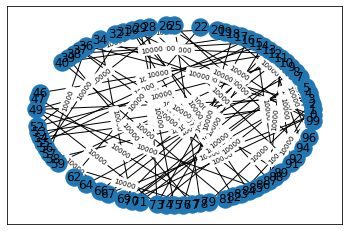

In [34]:
# VISUALIZATION
angles = np.linspace(0, 2*np.pi, 101)[:-1]
coords = [[np.cos(angles[i]), np.sin(angles[i])] for i in range(len(angles))]
pos = {}
for i in range(100):
    pos[i] = coords[i]

nx.draw_networkx(G,pos)
capacities = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=capacities, font_size=7)